In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from itertools import islice

import random
import numpy as np

# фиксируем все seed
random.seed(170)
np.random.seed(170)
torch.manual_seed(170)
torch.cuda.manual_seed(170)
torch.backends.cudnn.deterministic = True

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
#utils
import torch
from torch import utils
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
           ])

def mnist(batch_size=10, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    train_loader = utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=4,\
                                         sampler = torch.utils.data.sampler.RandomSampler([*range(1000)]))
    test_loader = utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False,num_workers=4,\
                                        sampler = torch.utils.data.sampler.RandomSampler([*range(1000)]))
    return train_loader, test_loader

def plot_mnist(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [0]:
train_loader, test_loader = mnist()

In [0]:
class Net(nn.Module):
    def __init__(self, log_softmax=False):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 10)
        self.log_softmax = log_softmax
        self.optim = optim.SGD(self.parameters(), lr=0.5)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = self.fc4(x)
        if self.log_softmax:
            x = F.log_softmax(x, dim=1)
        else:
            x = torch.log(F.softmax(x, dim=1))
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [0]:
def train(epoch, models):
    pred_m= []
    for batch_idx, (data, target) in enumerate(train_loader):
        # переводим на gpu, уменьшаем размер выборки
        data = data.to(device)
        target = target.to(device)
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()

            pred = output.data.max(1, keepdim=True)[1]
            correct = pred.eq(target.data.view_as(pred)).cpu().sum()
            pred_m.append(correct)
            
        if batch_idx % 50 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), len(train_loader) * len(data),
                100. * batch_idx / len(train_loader) )
            losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), len(train_loader) * len(data),
            100. * batch_idx / len(train_loader) )
        losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
        print(line + losses)
        # добавляем расчет среднего значения предсказаний
        correct_pct = [c.numpy() / len(data) for c in pred_m]

    return models[0]._loss.item(), round(np.mean(correct_pct),2)


In [0]:
# уберем одну из сетей для ускорения расчетов
models = [Net(True).to(device)]

In [0]:
avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, len(test_loader) * test_loader.batch_size, p)
line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

def test(models):
    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in test_loader:
            # переводим на gpu
            data = data.to(device)
            target = target.to(device)
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, reduction='sum').item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= (len(test_loader) * test_loader.batch_size)
    correct_pct = [100. * c / (len(test_loader) * test_loader.batch_size) for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)
    return test_loss[0],correct_pct[0]/100

In [18]:
train_loss_history = []
test_loss_history = []
accuracy_test_history = []
accuracy_train_history = []

for epoch in range(1, 181):
    loss_train_,acc_train_ = train(epoch, models) 
    loss_test_, acc_test_ = test(models)
    train_loss_history.append(loss_train_)
    test_loss_history.append(loss_test_)
    accuracy_test_history.append(acc_test_)
    accuracy_train_history.append(acc_train_)

Train Epoch: 1 [0/1000 (0%)]	Losses 0: 2.300399
Train Epoch: 1 [500/1000 (50%)]	Losses 0: 2.428642
Train Epoch: 1 [1000/1000 (100%)]	Losses 0: 2.250436
Test set:
0: Loss: 2.2746	Accuracy: 99/1000 (10%)

Train Epoch: 2 [0/1000 (0%)]	Losses 0: 2.395161
Train Epoch: 2 [500/1000 (50%)]	Losses 0: 1.973040
Train Epoch: 2 [1000/1000 (100%)]	Losses 0: 1.721138
Test set:
0: Loss: 1.7938	Accuracy: 339/1000 (34%)

Train Epoch: 3 [0/1000 (0%)]	Losses 0: 1.589839
Train Epoch: 3 [500/1000 (50%)]	Losses 0: 1.259254
Train Epoch: 3 [1000/1000 (100%)]	Losses 0: 1.218598
Test set:
0: Loss: 2.0820	Accuracy: 339/1000 (34%)

Train Epoch: 4 [0/1000 (0%)]	Losses 0: 1.400864
Train Epoch: 4 [500/1000 (50%)]	Losses 0: 0.532170
Train Epoch: 4 [1000/1000 (100%)]	Losses 0: 1.100362
Test set:
0: Loss: 1.1181	Accuracy: 561/1000 (56%)

Train Epoch: 5 [0/1000 (0%)]	Losses 0: 0.556608
Train Epoch: 5 [500/1000 (50%)]	Losses 0: 0.723539
Train Epoch: 5 [1000/1000 (100%)]	Losses 0: 0.480730
Test set:
0: Loss: 0.9276	Accurac

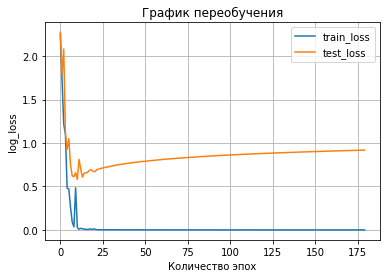

In [19]:
# построение графиков
plt.plot(train_loss_history, label = 'train_loss');
plt.plot(test_loss_history, label = 'test_loss');
plt.title('График переобучения');
plt.xlabel('Количество эпох')
plt.ylabel('log_loss')
plt.grid();
plt.legend();

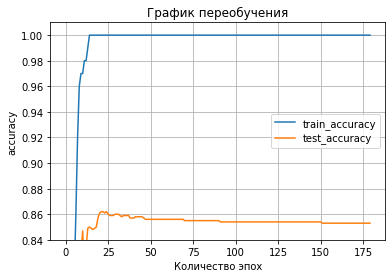

In [22]:
# тоже самое для accuracy
plt.plot(accuracy_train_history, label = 'train_accuracy');
plt.plot(accuracy_test_history, label = 'test_accuracy');
plt.title('График переобучения');
plt.xlabel('Количество эпох')
plt.ylabel('accuracy')
plt.ylim(bottom = 0.84,top = 1.01)
plt.grid();
plt.legend();